In [1]:
%matplotlib notebook
from PyLQR.sim import KDLRobot, TransformedSimulationInterface
from PyLQR.system import PosOrnPlannerSys, SequentialSystem, PosOrnKeypoint
from PyLQR.solver import BatchILQRCP, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage

import numpy as np
import matplotlib.pyplot as plt

# PyLQR: Position/Orientation planner or tracker example

In this example, we will present how to use iLQR to plan or track multiple systems that has for target space $\mathbf{\mu}_t$ expressed in an object frame :

* position in the object frame ``[x,y,z]``
* orientation in the object frame (in quaternion) ``[w,x,y,z]``

$$
    \mathbf{\mu}_t = \lbrack x \ y \ z \ w \ x \ y \ z \rbrack^\top
$$

For state space $\mathbf{x}_t$ (it is a latent space):

* joint positions $\mathbf{q}$

$$
    \mathbf{x}_t = \lbrack \mathbf{q}^\top \rbrack^\top
$$

For command space $\mathbf{u}_t$:

* joint velocities $\mathbf{\dot{q}}$

$$
    \mathbf{u}_t = \lbrack \mathbf{\dot{q}}^\top \rbrack^\top
$$

<span style="color:red">**The target space is get with the forward kinematics function expressed in the object frame with $\mathbf{x}_t$  as robot configuration**</span>

In [2]:
# Global task variables
dof = 7
nb_state_var = dof # [q]
nb_ctrl_var = dof  # [dq]
nb_fox_var = 7 # [pos,orn]
horizon=600
dt = 0.01

## Definition of the robot object

The first to do is to create the abstraction of the robot that we want to control. Here we will a robot's abstraction based on the KDL library. The ``KDLRobot`` class requires:

* An URDF file describing the robot that we want to use.
* The name of the base frame in the URDF
* The name of the tip frame in the URDF
* Initial joint configuration

This class will *simulate* the kinematics evolution of the Panda robot in function of the control command that we will send to him.

In [3]:
PATH_TO_URDF = "model.urdf"
BASE_FRAME = "panda_link0"
TIP_FRAME = "panda_tip"
q0 = [ 0.62991112, -0.2329776 , -0.01423721, -1.70254115,  0.06251303, # Initial joint configuration of the robot
        1.50592777,  0.71771416]
dq0 = [0]*dof

qMax = np.array([np.pi]*dof)*10
dqMax = np.array([10]*dof)
rbt = KDLRobot(PATH_TO_URDF,BASE_FRAME,TIP_FRAME,q0,dq0)

## Definition of the object frames

In this section, we will:

- Define the objects/targets in the robot's base frame
- Compute the homogeneous transformation matrix of the objects/targets with respect to the robot's base frame.
- Decide the position targets in the object base frames.
- Generate some nice plots.

But first let's define some helper functions:

In [4]:
def plot_pose_matrix(ax,T,label=None,scale=1):
    base = T[:3,-1]
    orn = T[:3,:3]
    ax.plot([base[0],base[0]+scale*orn[0,0]],[base[1],base[1]+scale*orn[1,0]],[base[2],base[2]+scale*orn[2,0]],c='r')
    ax.plot([base[0],base[0]+scale*orn[0,1]],[base[1],base[1]+scale*orn[1,1]],[base[2],base[2]+scale*orn[2,1]],c='g')
    ax.plot([base[0],base[0]+scale*orn[0,2]],[base[1],base[1]+scale*orn[1,2]],[base[2],base[2]+scale*orn[2,2]],c='b')
    
    if label is not None:
        ax.text(base[0],base[1],base[2],label)

def scatter_point_in_given_frame(ax,pos_in_frame,frame,c):  
    pos_world = frame[:3,:3] @ pos_in_frame + frame[:3,-1]
    ax.scatter(pos_world[0],pos_world[1],pos_world[2],c=c)
    return pos_world

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

Now, we compute the object frame. To do this, we have a prior knowledge on the object position and orientation in the robot's base frame (``obj1_rot_base_quat`` and ``obj1_pos_base``).

At the end we generate a plot to have a broader view.

<IPython.core.display.Javascript object>


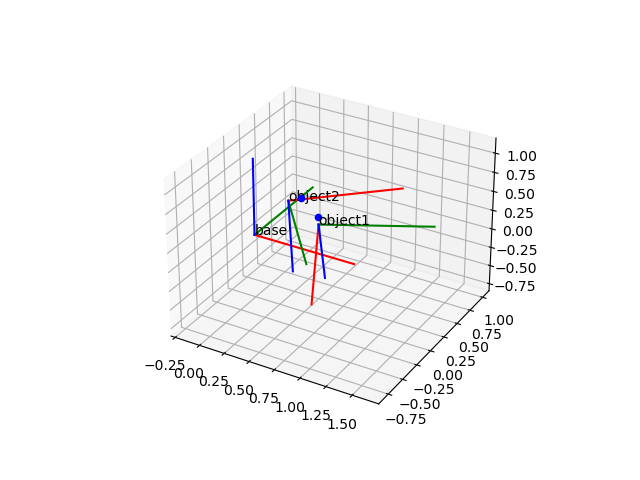

In [5]:
from scipy.spatial.transform import Rotation

base_frame = np.asarray([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1]
])

## Object 1
obj1_rot_base_quat = np.asarray([0.63758403393523, 0.2994657314658187, 0.6042309402208079, -0.37244039285286973])
obj1_rot_base_mat = Rotation.from_quat( np.hstack(( obj1_rot_base_quat[1:] , obj1_rot_base_quat[0] )) ).as_matrix()
obj1_pos_base = np.asarray([0.62,0.05,0.34])

obj1_frame = np.zeros((4,4))
obj1_frame[:3,:3] = obj1_rot_base_mat
obj1_frame[:3,-1] = obj1_pos_base
obj1_frame[-1,-1] = 1

target1_obj1_frame = np.asarray([0,0,-0.15])

## Object 2
obj2_rot_base_quat = np.asarray([-0.03647984,  0.94060485,  0.33742794,  0.00860923])
obj2_rot_base_mat = Rotation.from_quat( np.hstack(( obj2_rot_base_quat[1:] , obj2_rot_base_quat[0] )) ).as_matrix()
obj2_pos_base = np.asarray([0.32,0.05,0.54])

obj2_frame = np.zeros((4,4))
obj2_frame[:3,:3] = obj2_rot_base_mat
obj2_frame[:3,-1] = obj2_pos_base
obj2_frame[-1,-1] = 1

target2_obj2_frame = np.asarray([0.1,0.1,-0.1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_pose_matrix(ax,base_frame,'base')
plot_pose_matrix(ax,obj1_frame,'object1')
plot_pose_matrix(ax,obj2_frame,'object2')
target1_world_frame = scatter_point_in_given_frame(ax,target1_obj1_frame,obj1_frame,c='b')
target2_world_frame = scatter_point_in_given_frame(ax,target2_obj2_frame,obj2_frame,c='b')
set_axes_equal(ax)
plt.show()

Finally, we create other objects that will be in charge to compute every robot's information in the given frame (here the object frames):

In [6]:
transformed_robot1 = TransformedSimulationInterface(rbt,obj1_frame)
transformed_robot2 = TransformedSimulationInterface(rbt,obj2_frame)

## Task & system definition

Now that we have an object simulating the kinematics of our robot in the object frame, we have to build a system object that will describe the task that we want to perform. Here since we are looking to optimize position and orientation
we will instantiate an object of type ``PosOrnPlannerSys``. To create this object, we need:

* A list of Keypoints (here ``PosOrnKeypoint``), each element in this list represents a keypoint, it contains:
  * A position target
  * An orientation target
  * A precision matrix
  * A discrete time value (discrete time of occurence)
* Joint limits/special end-effector transforms. Optional (see below).
* Some extra-information about the system:
  * Control command penalty (rfactor)
  * Horizon of the problem
  * Order of the system (in this example it's 1)
  * The discrete time step (dt)

### Definition of system for object 1

In [7]:
target1_pos = target1_obj1_frame  # We use the position set in a previous cell
target1_orn = np.array([1,0,0,0])

Qtarget1 = np.diag([ # Precision matrix, here we track position and orientation.
    1,
    1,
    1,
    .0,
    .0,
    .0
])
target1_discrete_time = horizon//2 # Discrete occurence

keypoint1 = PosOrnKeypoint(target1_pos,target1_orn,Qtarget1,target1_discrete_time)

keypoints = [keypoint1]

# Command penalty (R)
cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist() # Each control signals have a penalty of 1e-5

# Creation of the system object here we pass the robot objects that gives result in the object base frame:
sys1 = PosOrnPlannerSys(transformed_robot1,keypoints,cmd_penalties,qMax,-qMax,dqMax,-dqMax,horizon,1,dt) 

## Definition of system for object 2

In [8]:
target2_pos = target2_obj2_frame  # We use the position set in a previous cell
target2_orn = np.array([1,0,0,0])

Qtarget2 = np.diag([ # Precision matrix, here we track position and orientation.
    1,
    1,
    1,
    .0,
    .0,
    .0
])
target2_discrete_time = horizon-1 # Discrete occurence

keypoint2 = PosOrnKeypoint(target2_pos,target2_orn,Qtarget2,target2_discrete_time)

keypoints = [keypoint2]

# Command penalty (R)
cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist() # Each control signals have a penalty of 1e-5

# Creation of the system object here we pass the robot objects that gives result in the object base frame:
sys2 = PosOrnPlannerSys(transformed_robot2,keypoints,cmd_penalties,qMax,-qMax,dqMax,-dqMax,horizon,1,dt) 

### Combining both systems

In [9]:
systems = [sys1,sys2]
sys = SequentialSystem(rbt,systems,cmd_penalties,horizon,1)

## Solver definition

Now that the robot and system object are defined, we will define two different solvers to optimize the system:

* A Batch Iterative LQR with control primitives.
* A standard iLQR

Because of the batch formulation, the first one can only be used as a planning algorithm. 
Seconde one can either be used as planning or tracking algorithm (by using either the resulting state sequences or the control gains).

Batch solution use a library of primitives to build the control command:

$$
    \mathbf{u} = \Psi \mathbf{w}
$$

Where $\mathbf{w}$ is the weight of each control primitives. To build the primitives, you can use the ``PyLQR.utils.primitives`` module.

In [10]:
u0_t = np.array([0]*(nb_ctrl_var) )
u0 = np.tile(u0_t,horizon-1)

K = 2
psi = primitives.build_psi_unitstep(horizon-1,K)
PSI = np.kron(psi,np.identity(nb_ctrl_var))

# For the batch solution, if you want to use of diagonal elements for Q or special construction of mu,
# you can override targets and precisions set in the system by replacing the 2 lines below by what you want.
# mu = sys.get_mu_vector(False)
# Q = sys.get_Q_matrix(False)

planner1 = BatchILQRCP(sys,PSI)
planner2 = ILQRRecursive(sys)

## Solving the iLQR problem

Now that the solvers have been defined, we will solve the iLQR problem, both solvers will return different things:

- The sparse solver only returns the list of control commands to apply on the robot. To get the joint positions/velocities and task space states, you need to send iteratively these commands to the robot object. Be careful to use the good object in function to what you want (object or robot frame).
- The iterative solver returns the list of: joint states, task space states, control commands, and gains. 
  - Since we are optimizing multiple systems with the ``SequentialSystem`` object, a task_space state is defined as the combination of the task space in all base frames:
  
$$
    f(\mathbf{x}_k) = \lbrack f(\mathbf{x}_k)_A^\top \quad f(\mathbf{x}_k)_B^\top \rbrack^\top
$$

In [11]:
cb = PythonCallbackMessage() # callback to notify python code of the solver evolution

In [12]:
%%time
U1 = planner1.solve(25,u0,True,cb)
U1 = U1.reshape((horizon-1,nb_ctrl_var))
rbt.set_conf(q0,dq0,True)
X1 = np.zeros((horizon,nb_state_var))
F_X1_world_frame = np.zeros((horizon,nb_fox_var))

X1[0] = rbt.get_q()
F_X1_world_frame[0] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn()))

for i in range(horizon-1):
    ut = U1[i]
    
    rbt.send_vel(dt,ut,True)
    
    X1[i+1] = rbt.get_q()
    F_X1_world_frame[i+1] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn() ))

Iteration 1, Cost: 0.174263, alpha= 1
Iteration 2, Cost: 0.0149049, alpha= 1
Iteration 3, Cost: 0.000251172, alpha= 1
Iteration 4, Cost: 0.000215869, alpha= 1
Iteration 5, Cost: 0.000215851, alpha= 1
Iteration 6, Cost: 0.000215851, alpha= 1
Iteration 7, Cost: 0.000215851, alpha= 0.000976562
CPU times: user 1.01 s, sys: 16.4 ms, total: 1.03 s
Wall time: 1.02 s


In [13]:
%%time
X2,F_X2,U2,K2,k2 = planner2.solve(u0.reshape((-1,nb_ctrl_var)),10,True,True,cb)

Iteration 1, Cost: 0.014658, alpha= 1, time= 0.00968182
Iteration 2, Cost: 3.97213e-05, alpha= 1, time= 0.00963845
Iteration 3, Cost: 1.38213e-06, alpha= 1, time= 0.00955753
Iteration 4, Cost: 1.34137e-06, alpha= 1, time= 0.00956179
Iteration 5, Cost: 1.34137e-06, alpha= 0.000976562, time= 0.0707731
CPU times: user 114 ms, sys: 4.8 ms, total: 118 ms
Wall time: 118 ms


In [14]:
for f_x_t in F_X2:
    f_x_t[:3] = obj1_frame[:3,:3] @ f_x_t[:3] + obj1_frame[:3,-1]

## Plotting

<IPython.core.display.Javascript object>


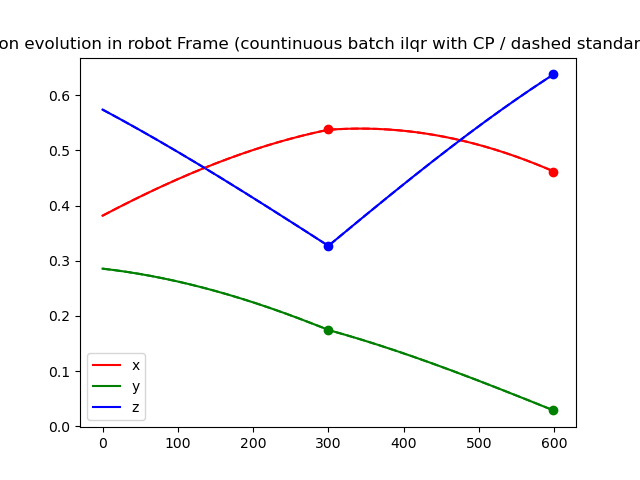

In [15]:
F_X2 = np.asarray(F_X2)

plt.figure()
plt.title('Position evolution in robot Frame (countinuous batch ilqr with CP / dashed standard iLQR)')

plt.plot(F_X1_world_frame[:,0],c='r',label='x')
plt.plot(F_X1_world_frame[:,1],c='g',label='y')
plt.plot(F_X1_world_frame[:,2],c='b',label='z')

plt.plot(F_X2[:,0],c='r',linestyle='dashed')
plt.plot(F_X2[:,1],c='g',linestyle='dashed')
plt.plot(F_X2[:,2],c='b',linestyle='dashed')

plt.scatter(horizon//2,target1_world_frame[0],c='r')
plt.scatter(horizon//2,target1_world_frame[1],c='g')
plt.scatter(horizon//2,target1_world_frame[2],c='b')

plt.scatter(horizon-1,target2_world_frame[0],c='r')
plt.scatter(horizon-1,target2_world_frame[1],c='g')
plt.scatter(horizon-1,target2_world_frame[2],c='b')

plt.legend()

<IPython.core.display.Javascript object>


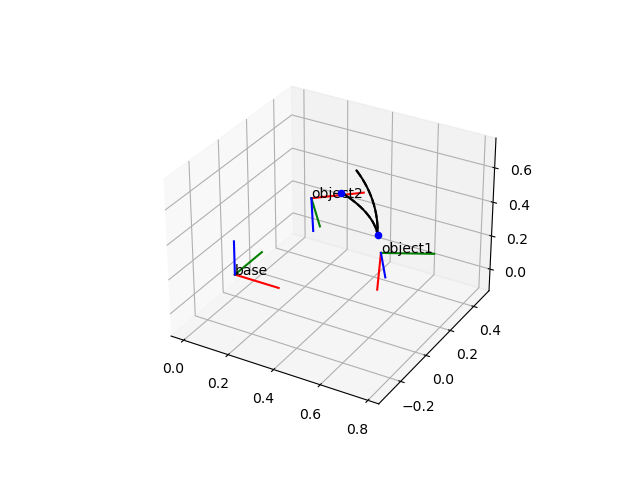

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_pose_matrix(ax,base_frame,'base',scale=.2)
plot_pose_matrix(ax,obj1_frame,'object1',scale=.2)
plot_pose_matrix(ax,obj2_frame,'object2',scale=.2)
target1_world_frame = scatter_point_in_given_frame(ax,target1_obj1_frame,obj1_frame,c='b')
target2_world_frame = scatter_point_in_given_frame(ax,target2_obj2_frame,obj2_frame,c='b')
ax.plot(F_X1_world_frame[:,0],F_X1_world_frame[:,1],F_X1_world_frame[:,2],c='black')
ax.plot(F_X2[:,0],F_X2[:,1],F_X2[:,2],c='black', linestyle="dashed")
set_axes_equal(ax)
plt.show()